# Figures & Evaluation Notebook

This notebook is dedicated to generating figures, evaluations, and additional statistics. 
It supplements the main thesis by producing:

- Visualization of detection results 
- Quantitative evaluations and extra statistical analyses  

> **Note:** This notebook is not part of the training pipeline; 
> it is focused purely on figure creation and evaluation for thesis documentation.

In [ ]:
import pandas as pd
import numpy as np
from PIL import Image
import glob
from functools import reduce
import os, re
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import sys
import os
import pandas as pd
from PIL import Image
import numpy as np

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

from tool.voc_eval_new import custom_voc_eval

In [ ]:
img = Image.open("C:/Users/Asus/Desktop/Cervical-Cancer-Detection/data/JPEGImages/1654bj005_0021.png")
print("size (W,H):", img.size)      
print("mode:", img.mode)            
print("bands:", img.getbands())     

is_rgb = (img.mode == "RGB")

size (W,H): (2048, 2048)
mode: RGB
bands: ('R', 'G', 'B')


In [13]:
df = pd.read_csv("C:/Users/Asus/Desktop/Cervical-Cancer-Detection/csvfiles/fold1/train.csv")
df1 = pd.read_csv("C:/Users/Asus/Desktop/Cervical-Cancer-Detection/csvfiles/fold1/val.csv")
df2 = pd.read_csv("C:/Users/Asus/Desktop/Cervical-Cancer-Detection/csvfiles/test.csv")

# Concatenate all splits
df3 = pd.concat([df, df1, df2], ignore_index=True)

# Count unique image paths
num_unique_paths = df3["image_path"].nunique()
print("Number of unique image paths:", num_unique_paths)

Number of unique image paths: 8036


In [14]:
# Count cells per row
df2["num_cells"] = df2["annotation"].apply(lambda x: len(x.split(";")) if pd.notna(x) else 0)

# Total number of annotated cells
total_cells = df2["num_cells"].sum()

print("Total annotated cells:", total_cells)

# If you also want cells per image:
print(df2[["image_path", "num_cells"]])

Total annotated cells: 1612
                                             image_path  num_cells
0     C:/Users/Asus/Desktop/Cervical-Cancer-Detectio...          1
1     C:/Users/Asus/Desktop/Cervical-Cancer-Detectio...          1
2     C:/Users/Asus/Desktop/Cervical-Cancer-Detectio...          1
3     C:/Users/Asus/Desktop/Cervical-Cancer-Detectio...          1
4     C:/Users/Asus/Desktop/Cervical-Cancer-Detectio...          2
...                                                 ...        ...
1106  C:/Users/Asus/Desktop/Cervical-Cancer-Detectio...          3
1107  C:/Users/Asus/Desktop/Cervical-Cancer-Detectio...          1
1108  C:/Users/Asus/Desktop/Cervical-Cancer-Detectio...          3
1109  C:/Users/Asus/Desktop/Cervical-Cancer-Detectio...          3
1110  C:/Users/Asus/Desktop/Cervical-Cancer-Detectio...          1

[1111 rows x 2 columns]


In [ ]:
# --- Helpers ---
space_re = re.compile(r"\s+")

def parse_boxes(ann):
    """Return a set of normalized box strings from an annotation field."""
    if pd.isna(ann) or str(ann).strip() == "":
        return set()
    parts = [p.strip() for p in str(ann).split(";") if p.strip()]
    # normalize inner whitespace so '0  12  34' == '0 12 34'
    norm = [space_re.sub(" ", p) for p in parts]
    return set(norm)

def union_sets(sets_iter):
    """Union a series/iterable of sets."""
    return reduce(lambda a, b: a | b, sets_iter, set())

# --- Load all folds' train/val + the single common test ---
all_dfs = []
for file in glob.glob(r"C:/Users/Asus/Desktop/Cervical-Cancer-Detection/csvfiles/fold*/**/*.csv", recursive=True):
    df = pd.read_csv(file)
    df["source_file"] = file
    all_dfs.append(df)

test_df = pd.read_csv(r"C:/Users/Asus/Desktop/Cervical-Cancer-Detection/csvfiles/test.csv")
test_df["source_file"] = "common_test"
all_dfs.append(test_df)

df_all = pd.concat(all_dfs, ignore_index=True)

# Parse boxes per row
df_all["boxes_set"] = df_all["annotation"].apply(parse_boxes)

# --- Deduplicate by image_path (union boxes across duplicates) ---
by_image = (
    df_all.groupby("image_path", as_index=False)
          .agg({
              "boxes_set": union_sets,
              # keep a representative patient_id (or join if you prefer)
              "patient_id": "first"
          })
)

by_image["num_cells"] = by_image["boxes_set"].apply(len)

# --- Final counts (deduped) ---
unique_images = len(by_image)
total_cells_deduped = by_image["num_cells"].sum()

print("Unique images (after dedup):", unique_images)
print("Total annotated cells (deduped):", total_cells_deduped)

# --- (Optional) Compare to naïve double-counting ---
df_all["num_cells_naive"] = df_all["boxes_set"].apply(len)
print("Total annotated cells (naïve, with duplicates):", df_all["num_cells_naive"].sum())

# --- (Optional) find images that had conflicting/extra boxes across folds ---
# i.e., union > max per-row count for that image
per_image_max = (
    df_all.groupby("image_path")["num_cells_naive"].max().rename("max_per_row")
)
check = by_image.merge(per_image_max, on="image_path", how="left")
changed = check[check["num_cells"] > check["max_per_row"]]
print("Images where union added boxes (possible annotation diffs across folds):", len(changed))

Unique images (after dedup): 8036
Total annotated cells (deduped): 15762
Total annotated cells (naïve, with duplicates): 72357
Images where union added boxes (possible annotation diffs across folds): 1


In [8]:
train_df = pd.read_csv("C:/Users/Asus/Desktop/Cervical-Cancer-Detection/csvfiles/fold1/train.csv")
val_df   = pd.read_csv("C:/Users/Asus/Desktop/Cervical-Cancer-Detection/csvfiles/fold1/val.csv")
test_df  = pd.read_csv("C:/Users/Asus/Desktop/Cervical-Cancer-Detection/csvfiles/test.csv")

# Count unique images in each split
n_train = train_df["image_path"].nunique()
n_val   = val_df["image_path"].nunique()
n_test  = test_df["image_path"].nunique()

total   = n_train + n_val + n_test

# Percentages
p_train = (n_train / total) * 100
p_val   = (n_val / total) * 100
p_test  = (n_test / total) * 100

print(f"Train: {n_train} images ({p_train:.2f}%)")
print(f"Val:   {n_val} images ({p_val:.2f}%)")
print(f"Test:  {n_test} images ({p_test:.2f}%)")
print(f"Total: {total} images")

Train: 5577 images (69.40%)
Val:   1348 images (16.77%)
Test:  1111 images (13.83%)
Total: 8036 images


Saved figure to: C:/Users/Asus/Desktop/Cervical-Cancer-Detection/results/4_sample_bboxes.png


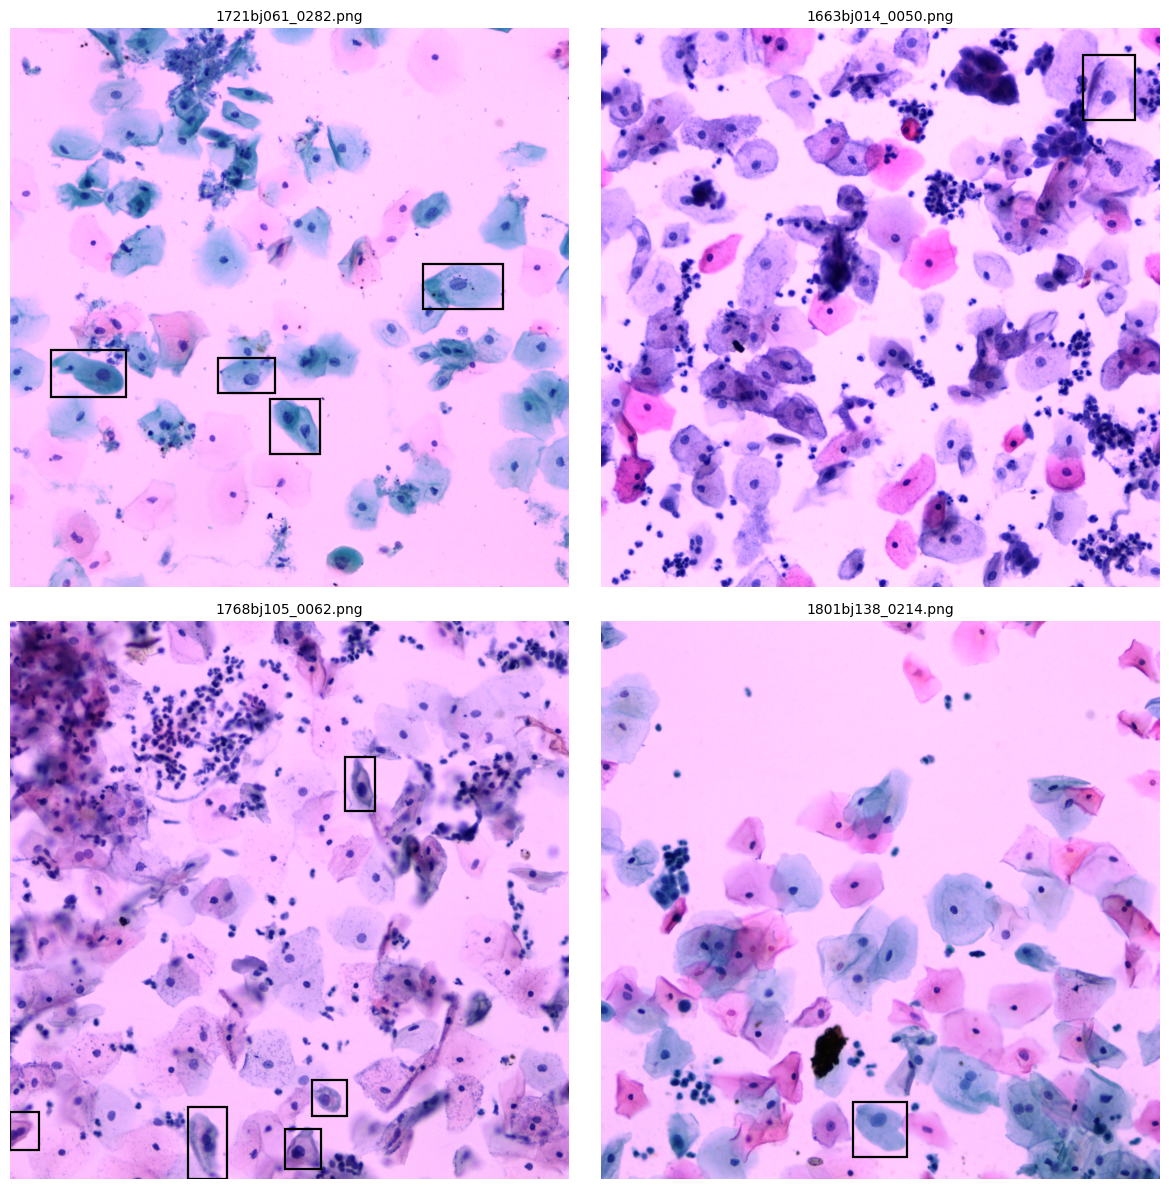

In [ ]:
# -----------------------------
# CONFIG (adjust paths if needed)
# -----------------------------
CSV_TRAIN = r"C:/Users/Asus/Desktop/Cervical-Cancer-Detection/csvfiles/fold1/train.csv"
CSV_VAL   = r"C:/Users/Asus/Desktop/Cervical-Cancer-Detection/csvfiles/fold1/val.csv"
CSV_TEST  = r"C:/Users/Asus/Desktop/Cervical-Cancer-Detection/csvfiles/test.csv"  # common test
SAVE_PATH = r"C:/Users/Asus/Desktop/Cervical-Cancer-Detection/results/4_sample_bboxes.png"
RANDOM_SEED = 42         # set for reproducibility; change/remove for different random picks
N_SAMPLES = 4            # number of images to draw
FIGSIZE = (12, 12)       # big figure for print
LINEWIDTH = 1.6          # bbox line width
TITLE_FONTSIZE = 10      # file name title
LABEL_FONTSIZE = 8       # class id label near box
DPI = 600                # publication quality
# -----------------------------

rng = np.random.default_rng(RANDOM_SEED)
space_re = re.compile(r"\s+")

def parse_boxes(ann):
    """
    Parse 'class x1 y1 x2 y2; ...' into a set of tuples (cls, x1, y1, x2, y2).
    Whitespace is normalized; malformed chunks are skipped.
    """
    if pd.isna(ann) or str(ann).strip() == "":
        return set()
    out = []
    for chunk in str(ann).split(";"):
        chunk = space_re.sub(" ", chunk.strip())
        if not chunk:
            continue
        parts = chunk.split(" ")
        if len(parts) != 5:
            continue
        cls, x1, y1, x2, y2 = parts
        try:
            out.append((int(cls), int(float(x1)), int(float(y1)), int(float(x2)), int(float(y2))))
        except Exception:
            continue
    return set(out)

def union_sets(sets_iter):
    return reduce(lambda a, b: a | b, sets_iter, set())

# 1) Load fold1 train + val + common test
df_train = pd.read_csv(CSV_TRAIN)
df_val   = pd.read_csv(CSV_VAL)
df_test  = pd.read_csv(CSV_TEST)

df_all = pd.concat([df_train, df_val, df_test], ignore_index=True)

# 2) Parse boxes and (defensively) deduplicate by image_path with union of boxes
df_all["boxes_set"] = df_all["annotation"].apply(parse_boxes)
by_image = (
    df_all.groupby("image_path", as_index=False)
          .agg({"boxes_set": union_sets, "patient_id": "first"})
)

# 3) Sample 4 unique images
if len(by_image) < N_SAMPLES:
    raise ValueError(f"Not enough images to sample {N_SAMPLES}; found {len(by_image)}.")
sample_idx = rng.choice(len(by_image), size=N_SAMPLES, replace=False)
sampled = by_image.iloc[sample_idx].reset_index(drop=True)

# 4) Plot 2x2 with bounding boxes and save high-res PNG
fig, axes = plt.subplots(2, 2, figsize=FIGSIZE)
axes = axes.ravel()

for ax, (_, row) in zip(axes, sampled.iterrows()):
    img_path = row["image_path"]
    boxes = row["boxes_set"]

    # Load and show image
    with Image.open(img_path) as im:
        ax.imshow(im)
    ax.set_title(os.path.basename(img_path), fontsize=TITLE_FONTSIZE)
    ax.axis("off")

    # Draw boxes
    for (cls, x1, y1, x2, y2) in boxes:
        w, h = x2 - x1, y2 - y1
        rect = Rectangle((x1, y1), w, h, fill=False, linewidth=LINEWIDTH)
        ax.add_patch(rect)

plt.tight_layout()
plt.savefig(SAVE_PATH, dpi=DPI, bbox_inches="tight")
print(f"Saved figure to: {SAVE_PATH}")
plt.show()

Saved figure to: C:/Users/Asus/Desktop/Cervical-Cancer-Detection/results/grid_gt_vs_cnn_vs_vitdet.png


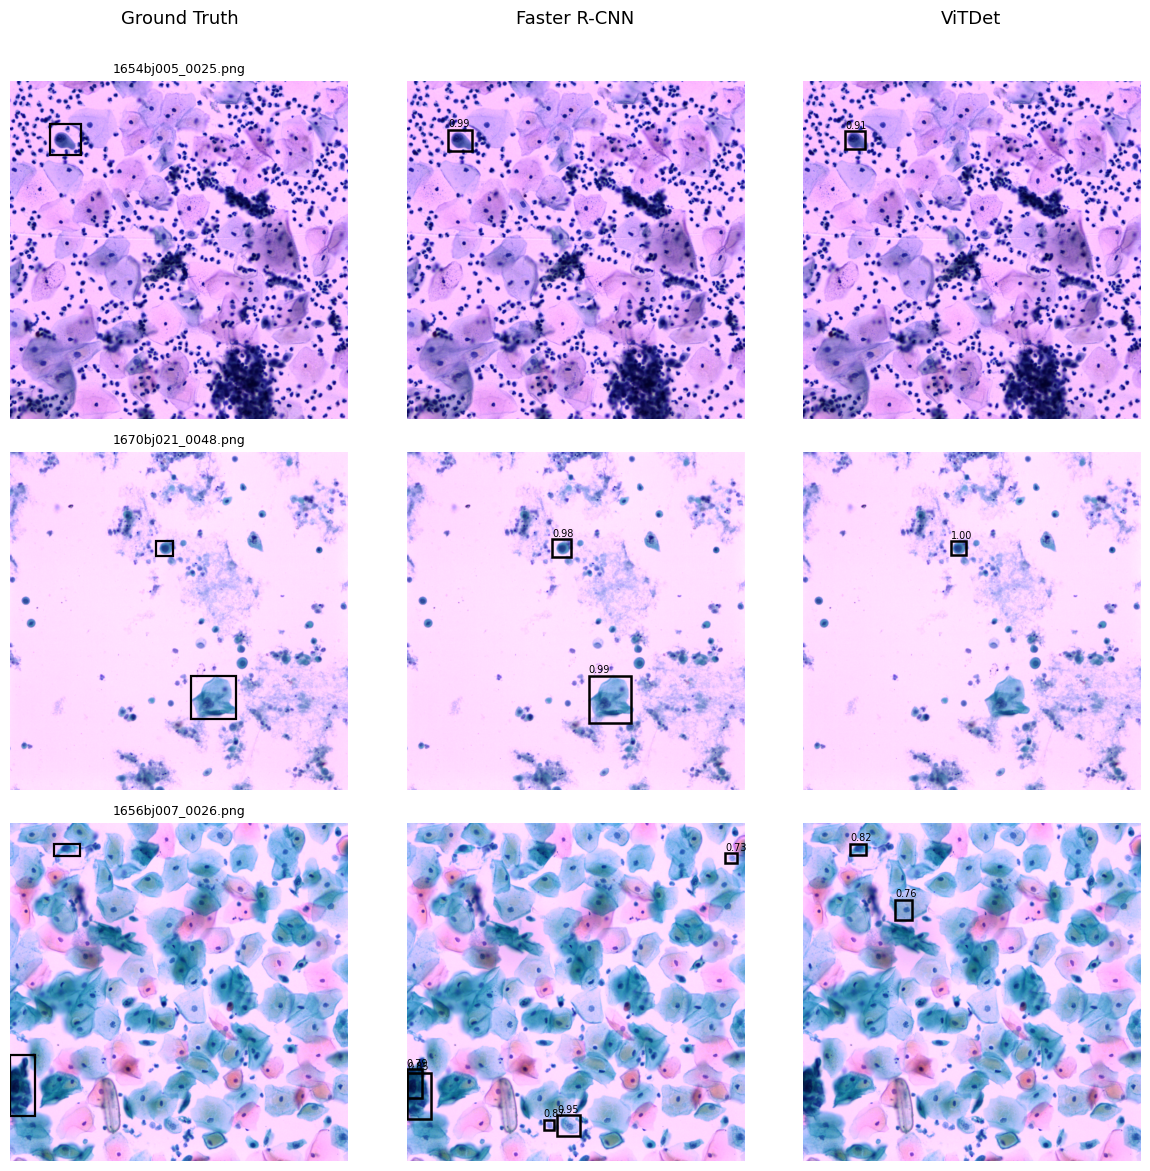

In [ ]:
# -----------------------------
# CONFIG
# -----------------------------
CSV_TEST = r"C:/Users/Asus/Desktop/Cervical-Cancer-Detection/csvfiles/test.csv"   # ONLY test set for GT
CSV_PRED_VIT = r"C:/Users/Asus/Desktop/Cervical-Cancer-Detection/results/vit/output/predictions.csv"  # ViTDet predictions
CSV_PRED_CNN = r"C:/Users/Asus/Desktop/Cervical-Cancer-Detection/results/cnn/cnn aws/cnn2/fold1/test_loc_07.csv"  # Faster R-CNN predictions

SAVE_PATH = r"C:/Users/Asus/Desktop/Cervical-Cancer-Detection/results/grid_gt_vs_cnn_vs_vitdet.png"

TARGET_IMAGES = [
    r"C:/Users/Asus/Desktop/Cervical-Cancer-Detection/data/JPEGImages/1654bj005_0025.png",
    r"C:/Users/Asus/Desktop/Cervical-Cancer-Detection/data/JPEGImages/1670bj021_0048.png",
    r"C:/Users/Asus/Desktop/Cervical-Cancer-Detection/data/JPEGImages/1656bj007_0026.png",
]

FIGSIZE = (12, 12)       # 3 rows × 3 columns
LINEWIDTH_GT = 1.6       # bbox line width for GT
LINEWIDTH_PRED = 1.8     # bbox line width for predictions
TITLE_FONTSIZE = 9       # image title (file name)
COL_TITLE_SIZE = 13      # column titles
DPI = 600                # publication quality
SCORE_THRESH_VIT = 0.5   # draw ViTDet preds with score >= this
SCORE_THRESH_CNN = 0.5   # draw Faster R-CNN preds with score >= this
# -----------------------------

space_re = re.compile(r"\s+")

def parse_gt_boxes(ann):
    """Parse GT: 'class x1 y1 x2 y2; ...' -> set[(cls, x1, y1, x2, y2)]"""
    if pd.isna(ann) or str(ann).strip() == "":
        return set()
    out = []
    for chunk in str(ann).split(";"):
        chunk = space_re.sub(" ", chunk.strip())
        if not chunk:
            continue
        parts = chunk.split(" ")
        if len(parts) != 5:
            continue
        cls, x1, y1, x2, y2 = parts
        try:
            out.append((int(cls), int(float(x1)), int(float(y1)), int(float(x2)), int(float(y2))))
        except Exception:
            continue
    return set(out)

def parse_pred_line(pred_str, score_thresh):
    """
    Parse predictions: 'class score x1 y1 x2 y2; ...'
    -> list[(cls, score, x1, y1, x2, y2)] filtered by score.
    """
    if pd.isna(pred_str) or str(pred_str).strip() == "":
        return []
    out = []
    for chunk in str(pred_str).split(";"):
        chunk = space_re.sub(" ", chunk.strip())
        if not chunk:
            continue
        parts = chunk.split(" ")
        if len(parts) != 6:
            continue
        cls, score, x1, y1, x2, y2 = parts
        try:
            cls_i = int(cls)
            score_f = float(score)
            if score_f < score_thresh:
                continue
            x1 = int(float(x1)); y1 = int(float(y1))
            x2 = int(float(x2)); y2 = int(float(y2))
            out.append((cls_i, score_f, x1, y1, x2, y2))
        except Exception:
            continue
    return out

def union_sets(sets_iter):
    return reduce(lambda a, b: a | b, sets_iter, set())

def canon_path(p):
    """Canonicalize path for robust matching across machines."""
    return os.path.normpath(str(p)).replace("\\", "/").casefold()

def build_pred_maps(df, score_thresh):
    """
    Build two maps:
      - by full canonical path
      - by filename (basename) as a fallback
    """
    full_map, base_map = {}, {}
    for _, r in df.iterrows():
        ipath = r["image_path"]
        pred_str = r["prediction"]
        preds = parse_pred_line(pred_str, score_thresh)
        if preds is None:
            preds = []
        full_key = canon_path(ipath)
        full_map[full_key] = preds
        base_key = os.path.basename(full_key)
        base_map[base_key] = preds
    return full_map, base_map

# ---- Load GT from ONLY the test CSV
df_test = pd.read_csv(CSV_TEST)
df_test["boxes_set"] = df_test["annotation"].apply(parse_gt_boxes)
by_image_gt = (
    df_test.groupby("image_path", as_index=False)
           .agg({"boxes_set": union_sets, "patient_id": "first"})
)
gt_map = {canon_path(row["image_path"]): row for _, row in by_image_gt.iterrows()}

# ---- Load ViTDet predictions
df_vit = pd.read_csv(CSV_PRED_VIT)
if df_vit.columns.tolist()[:2] != ["image_path", "prediction"]:
    cols = df_vit.columns.tolist()
    df_vit = df_vit.rename(columns={cols[0]: "image_path", cols[1]: "prediction"})
vit_full_map, vit_base_map = build_pred_maps(df_vit, SCORE_THRESH_VIT)

# ---- Load Faster R-CNN predictions
df_cnn = pd.read_csv(CSV_PRED_CNN)
if df_cnn.columns.tolist()[:2] != ["image_path", "prediction"]:
    cols = df_cnn.columns.tolist()
    df_cnn = df_cnn.rename(columns={cols[0]: "image_path", cols[1]: "prediction"})
cnn_full_map, cnn_base_map = build_pred_maps(df_cnn, SCORE_THRESH_CNN)

# ---- Build grid (3 rows × 3 cols): [GT | Faster R-CNN | ViTDet]
n_rows = len(TARGET_IMAGES)
n_cols = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=FIGSIZE)
if n_rows == 1:
    axes = axes.reshape(1, -1)

for i, raw_path in enumerate(TARGET_IMAGES):
    key_full = canon_path(raw_path)
    key_base = os.path.basename(key_full)

    # --- Column 0: Ground Truth
    ax_gt = axes[i, 0]
    if key_full not in gt_map:
        ax_gt.text(0.5, 0.5, "GT not found\nin test.csv", ha="center", va="center")
        ax_gt.axis("off")
    else:
        with Image.open(raw_path) as im:
            ax_gt.imshow(im)
        ax_gt.set_title(os.path.basename(raw_path), fontsize=TITLE_FONTSIZE)
        ax_gt.axis("off")
        for (cls, x1, y1, x2, y2) in gt_map[key_full]["boxes_set"]:
            w, h = x2 - x1, y2 - y1
            rect = Rectangle((x1, y1), w, h, fill=False, linewidth=LINEWIDTH_GT)
            ax_gt.add_patch(rect)

    # --- Column 1: Faster R-CNN predictions (no GT overlay)
    ax_cnn = axes[i, 1]
    with Image.open(raw_path) as im:
        ax_cnn.imshow(im)
    ax_cnn.axis("off")
    preds_cnn = cnn_full_map.get(key_full, cnn_base_map.get(key_base, []))
    if not preds_cnn:
        ax_cnn.text(0.5, 0.5, "No predictions", ha="center", va="center")
    else:
        for (cls, score, x1, y1, x2, y2) in preds_cnn:
            w, h = x2 - x1, y2 - y1
            rect = Rectangle((x1, y1), w, h, fill=False, linewidth=LINEWIDTH_PRED)
            ax_cnn.add_patch(rect)
            ax_cnn.text(x1, max(0, y1 - 3), f"{score:.2f}", fontsize=7, va="bottom")

    # --- Column 2: ViTDet predictions (no GT overlay)
    ax_vit = axes[i, 2]
    with Image.open(raw_path) as im:
        ax_vit.imshow(im)
    ax_vit.axis("off")
    preds_vit = vit_full_map.get(key_full, vit_base_map.get(key_base, []))
    if not preds_vit:
        ax_vit.text(0.5, 0.5, "No predictions", ha="center", va="center")
    else:
        for (cls, score, x1, y1, x2, y2) in preds_vit:
            w, h = x2 - x1, y2 - y1
            rect = Rectangle((x1, y1), w, h, fill=False, linewidth=LINEWIDTH_PRED)
            ax_vit.add_patch(rect)
            ax_vit.text(x1, max(0, y1 - 3), f"{score:.2f}", fontsize=7, va="bottom")

# Column titles
fig.text(0.17, 0.96, "Ground Truth", ha="center", fontsize=COL_TITLE_SIZE)
fig.text(0.50, 0.96, "Faster R-CNN", ha="center", fontsize=COL_TITLE_SIZE)
fig.text(0.83, 0.96, "ViTDet", ha="center", fontsize=COL_TITLE_SIZE)

plt.tight_layout(rect=[0, 0, 1, 0.94])
os.makedirs(os.path.dirname(SAVE_PATH), exist_ok=True)
plt.savefig(SAVE_PATH, dpi=DPI, bbox_inches="tight")
print(f"Saved figure to: {SAVE_PATH}")
plt.show()

In [ ]:
df = pd.read_csv('C:/Users/Asus/Desktop/Cervical-Cancer-Detection/results/cnn/cnn aws/cnn2/fold1/test_loc.csv')
def filter_predictions(pred_str, threshold=0.7):
    if pd.isna(pred_str) or pred_str.strip() == "":
        return ""
    preds = pred_str.split(";")
    filtered = []
    for p in preds:
        parts = p.strip().split()
        if len(parts) > 1:  # ensure valid prediction
            score = float(parts[1])
            if score > threshold:
                filtered.append(p)
    return ";".join(filtered)

# Apply filter
df["prediction"] = df["prediction"].apply(lambda x: filter_predictions(x, 0.7))
old_prefix = "C:/Users/Administrator/Desktop/Cervical-Cancer-Detection/data/JPEGImages/"
new_prefix = "C:/Users/Asus/Desktop/Cervical-Cancer-Detection/data/JPEGImages/"

df["image_path"] = df["image_path"].str.replace(old_prefix, new_prefix, regex=False)
df.to_csv('C:/Users/Asus/Desktop/Cervical-Cancer-Detection/results/cnn/cnn aws/cnn2/fold1/test_loc_07.csv', index=False)

testap_dict,test_mAP,testmf1 = custom_voc_eval(
    gt_csv="C:/Users/Asus/Desktop/Cervical-Cancer-Detection/csvfiles/test.csv",
    pred_csv='C:/Users/Asus/Desktop/Cervical-Cancer-Detection/results/cnn/cnn aws/cnn2/fold1/test_loc_07.csv', ovthresh=0.01
) 
print(f"Test TCT AP :{testap_dict['1']:.4f}")
print(f"Test mAP: {test_mAP:.4f}")
print(f"Test F1-score: {testmf1:.4f}")



Number of predicted boxes: 2627
Number of true positive boxes: 1387.0
Number of false positive boxes: 1240.0
Test TCT AP :0.7369
Test mAP: 0.7369
Test F1-score: 0.6544


# End of the Notebook.